# Download Fire Perimeter Data from WIFIRE Firemap

**What this notebook does:**
1. Search for a fire by name and year
2. Download all perimeter updates from WIFIRE Firemap
3. Validate the timeline (check for duplicates/errors)
4. Save as GeoJSON for FARSITE simulation
5. Visualize perimeter evolution

**Data source:**
- [WIFIRE Firemap](https://firemap.sdsc.edu/) - Historical fire perimeters from mapped data
- Layer: `view_historical_fires`
- Contains actual mapped perimeters with timestamps

**Requirements:**
- Internet connection
- Fire name (case-sensitive)
- Fire year

---

## Setup

In [1]:
import requests
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from pathlib import Path
from shapely.geometry import Polygon, MultiPolygon

print("✓ Imports loaded")

✓ Imports loaded


## 1. Define Your Fire

**IMPORTANT: Fire name must match exactly** (case-sensitive). Check [WIFIRE Firemap](https://firemap.sdsc.edu/) if unsure.

In [2]:
# ========== USER INPUTS ==========

FIRE_NAME = "BORDER 2"      # Note: Most fire names are listed in all upper-case letters, but some are not.
FIRE_YEAR = 2025            # Year the fire occurred

OUTPUT_DIR = Path("fire_perimeters")  # Where to save downloaded data

# ==================================

## 2. Query WIFIRE Firemap

Search the WFS (Web Feature Service) API for all perimeter records:

In [3]:
FIREMAP_WFS_URL = "https://firemap.sdsc.edu/geoserver/wfs"

params = {
    "SERVICE": "WFS",
    "VERSION": "2.0.0",
    "REQUEST": "GetFeature",
    "TYPENAMES": "WIFIRE:view_historical_fires",
    "CQL_FILTER": f"fire_name = '{FIRE_NAME}' AND year = {FIRE_YEAR}",
    "OUTPUTFORMAT": "application/json",
    "SRSNAME": "EPSG:4326",
}

print(f"Searching for '{FIRE_NAME}' ({FIRE_YEAR})...")
response = requests.get(FIREMAP_WFS_URL, params=params, timeout=30)
response.raise_for_status()

data = response.json()
features = data.get("features", [])

if not features:
    raise ValueError(
        f"No perimeters found for '{FIRE_NAME}' ({FIRE_YEAR}).\n"
        f"Check that the fire name is spelled exactly as it appears in Firemap.\n"
        f"Hint: Most fires use ALL CAPS (e.g., 'BORDER 2', 'MARIA', 'WOOLSEY')"
    )

print(f"✓ Found {len(features)} perimeter(s)")

Searching for 'BORDER 2' (2025)...
✓ Found 6 perimeter(s)


## 3. Parse and Clean Data

Convert to GeoDataFrame and process timestamps:

In [4]:
# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(features, crs="EPSG:4326")

# Parse datetime (format: "2025-01-24Z" or "2025-01-24T00:00:00Z")
gdf['datetime'] = pd.to_datetime(
    gdf['perimeter_timestamp'].str.rstrip('Z'), 
    utc=False
)

# Convert MultiPolygon to largest single Polygon
def get_largest_polygon(geom):
    if isinstance(geom, Polygon):
        return geom
    elif isinstance(geom, MultiPolygon):
        return max(geom.geoms, key=lambda g: g.area)
    else:
        raise TypeError(f"Unexpected geometry type: {type(geom)}")

gdf['geometry'] = gdf['geometry'].apply(get_largest_polygon)

# Sort oldest to newest
gdf = gdf.sort_values('datetime', ascending=True).reset_index(drop=True)

# Convert to FARSITE projection (NAD83 Albers)
gdf = gdf.to_crs("EPSG:5070")

print(f"✓ Data cleaned and reprojected to EPSG:5070")

✓ Data cleaned and reprojected to EPSG:5070


## 4. Validate Timeline

Check for duplicate timestamps or data quality issues:

In [5]:
print("\n" + "="*60)
print(f"PERIMETER TIMELINE - {FIRE_NAME}")
print("="*60)

for i, row in gdf.iterrows():
    area_km2 = row.geometry.area / 1e6
    acres = row.get('acres', area_km2 * 247.105)  # Convert if not provided
    print(f"[{i}] {row['datetime']}  |  {area_km2:.2f} km²  |  {acres:.0f} acres")

# Check for duplicates
time_diffs = gdf['datetime'].diff().dropna()
duplicates = (time_diffs == pd.Timedelta(0)).sum()

if duplicates > 0:
    print(f"\nWARNING: {duplicates} duplicate timestamp(s) detected!")
    print("   This may cause issues in sequential simulation.")
else:
    print(f"\n✓ No duplicate timestamps")

# Time range
duration = gdf['datetime'].iloc[-1] - gdf['datetime'].iloc[0]
print(f"\nFire duration: {duration}")
print(f"First perimeter: {gdf['datetime'].iloc[0]}")
print(f"Last perimeter:  {gdf['datetime'].iloc[-1]}")


PERIMETER TIMELINE - BORDER 2
[0] 2025-01-23 00:00:00  |  2.29 km²  |  nan acres
[1] 2025-01-23 00:00:00  |  2.29 km²  |  567 acres
[2] 2025-01-23 00:00:00  |  2.29 km²  |  566 acres
[3] 2025-01-24 00:00:00  |  17.14 km²  |  4235 acres
[4] 2025-01-24 00:00:00  |  25.33 km²  |  6273 acres
[5] 2025-01-26 00:00:00  |  26.67 km²  |  6625 acres

   This may cause issues in sequential simulation.

Fire duration: 3 days 00:00:00
First perimeter: 2025-01-23 00:00:00
Last perimeter:  2025-01-26 00:00:00


## 5. Save Data

Export as GeoJSON for use in FARSITE workflow:

In [6]:
OUTPUT_DIR.mkdir(exist_ok=True)

# Save copy for export (GeoJSON doesn't support timezone-aware datetimes)
save_gdf = gdf.copy()
save_gdf['datetime'] = save_gdf['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%S')

output_file = OUTPUT_DIR / f"{FIRE_NAME.lower().replace(' ', '_')}_perimeters.geojson"
save_gdf.to_file(output_file, driver="GeoJSON")

print(f"✓ Saved {len(gdf)} perimeters to:")
print(f"  {output_file}")

# Also save metadata
metadata = {
    "fire_name": FIRE_NAME,
    "year": FIRE_YEAR,
    "n_perimeters": len(gdf),
    "start_date": str(gdf['datetime'].iloc[0]),
    "end_date": str(gdf['datetime'].iloc[-1]),
    "duration_days": duration.days,
    "total_area_km2": float(gdf['geometry'].iloc[-1].area / 1e6),
    "data_source": "WIFIRE Firemap WFS (view_historical_fires)"
}

import json
metadata_file = OUTPUT_DIR / f"{FIRE_NAME.lower().replace(' ', '_')}_metadata.json"
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"  {metadata_file}")

✓ Saved 6 perimeters to:
  fire_perimeters/border_2_perimeters.geojson
  fire_perimeters/border_2_metadata.json


## 6. Visualize Perimeter Evolution

Plot all perimeters on a map with basemap:

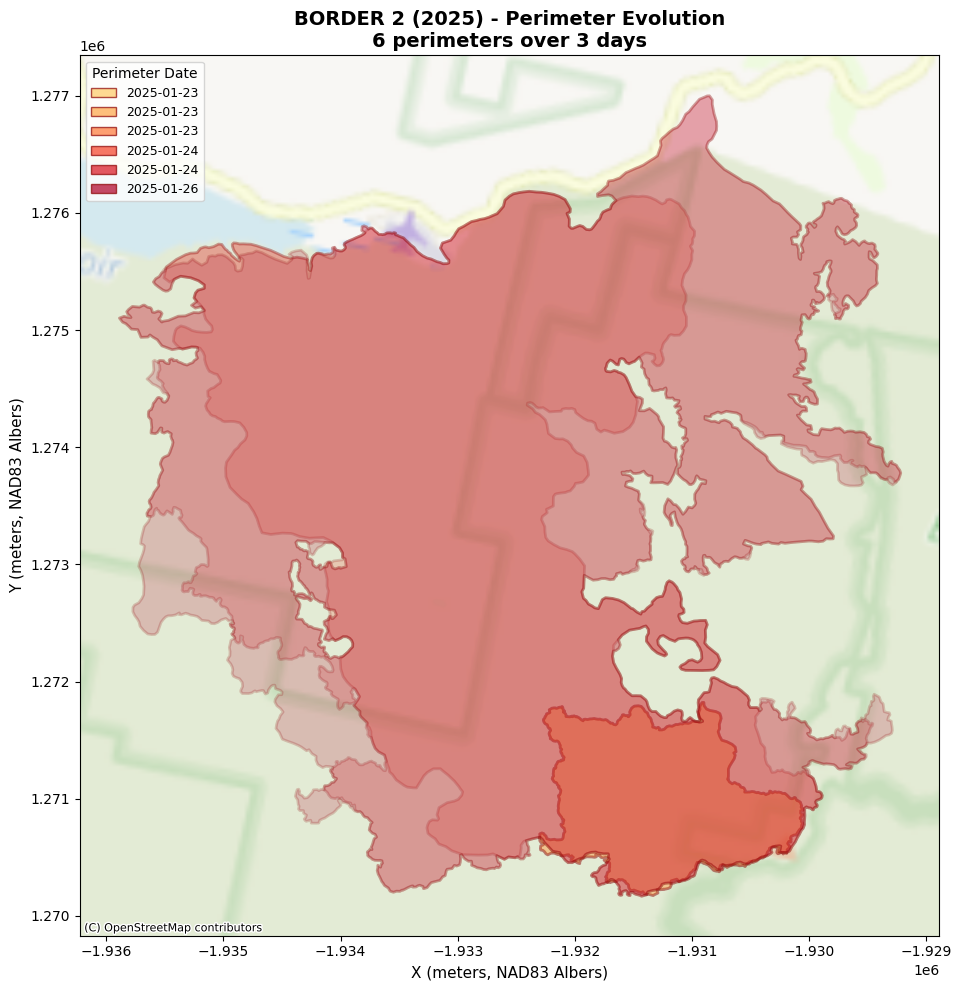

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot perimeters (oldest to newest)
import numpy as np
colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(gdf)))

for i, row in gdf.iterrows():
    gdf.iloc[[i]].plot(
        ax=ax,
        facecolor=colors[i],
        edgecolor='darkred',
        linewidth=2,
        alpha=0.2 
    )

# Add basemap
try:
    ctx.add_basemap(
        ax, 
        crs=gdf.crs.to_string(), 
        source=ctx.providers.OpenStreetMap.Mapnik,
        zoom=12,
        alpha=0.5
    )
except:
    print("Note: Could not add basemap (likely offline)")

# Create custom legend with dates
from matplotlib.patches import Patch
if len(gdf) <= 6:
    # Show all dates if 6 or fewer
    legend_elements = [
        Patch(facecolor=colors[i], edgecolor='darkred', alpha=0.7,
              label=f"{row['datetime'].strftime('%Y-%m-%d')}")
        for i, row in gdf.iterrows()
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=9, title='Perimeter Date')
else:
    legend_elements = [
        Patch(facecolor=colors[0], edgecolor='darkred', alpha=0.7,
              label=f"First: {gdf['datetime'].iloc[0].strftime('%Y-%m-%d')}"),
        Patch(facecolor=colors[-1], edgecolor='darkred', alpha=0.7,
              label=f"Last: {gdf['datetime'].iloc[-1].strftime('%Y-%m-%d')}"),
        Patch(facecolor='none', edgecolor='none', 
              label=f"({len(gdf)} total perimeters)")
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Axis labels with units (m), coordinate geometry (X,Y), and projection name (NAD83 Albers)
ax.set_xlabel('X (meters, NAD83 Albers)', fontsize=11)
ax.set_ylabel('Y (meters, NAD83 Albers)', fontsize=11)
ax.set_title(
    f"{FIRE_NAME} ({FIRE_YEAR}) - Perimeter Evolution\n"
    f"{len(gdf)} perimeters over {duration.days} days",
    fontsize=14,
    fontweight='bold'
)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## Summary

**Downloaded files:**
```
fire_perimeters/
├── <fire_name>_perimeters.geojson   # All perimeters (EPSG:5070)
└── <fire_name>_metadata.json        # Fire information
```

**Next steps: Use these perimeters in a wildfire digital twin workflow!**

---

**Try out these other fire names:**
- `"Maria"` (2019, Ventura County)
- `"WOOLSEY"` (2018, Los Angeles/Ventura)
- `"CAMP"` (2018, Butte County)
- `"THOMAS"` (2017, Ventura County)


**Notes:**
- Historical fire perimeters: CAL FIRE FRAP Program, NIFC, USGS GeoMAC, and BLM
- Active fire perimeters: NIFC

**Reference:**
- [WIFIRE Firemap F.A.Q.](https://wifire.ucsd.edu/firemap-faq)
- [OGC WFS Standard](https://www.ogc.org/standards/wfs)